In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error
import math

In [3]:
from fbprophet import Prophet
import pickle

In [4]:
df_sales = pickle.load(open('data/sales_df_all.pickle','rb'))

df_sales['Date'].unique()[[1,-1]] # data from 2013-01-01 to 2015-07-30

array(['2015-07-30T00:00:00.000000000', '2013-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [5]:
df_train = df_sales[df_sales['Date'] < '2015-01-01']
df_test = df_sales[df_sales['Date'] >= '2015-01-01']

In [6]:
def sales_prediction(Store_ID, sales_df, periods):
  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df[['Date','Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df.sort_values('ds')

  # fitting the model
  model = Prophet()
  model.fit(sales_df)
  # making prediction
  future = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)

  return model, forecast

In [7]:
prediction = sales_prediction(84, df_train, 30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 2121.538214292003


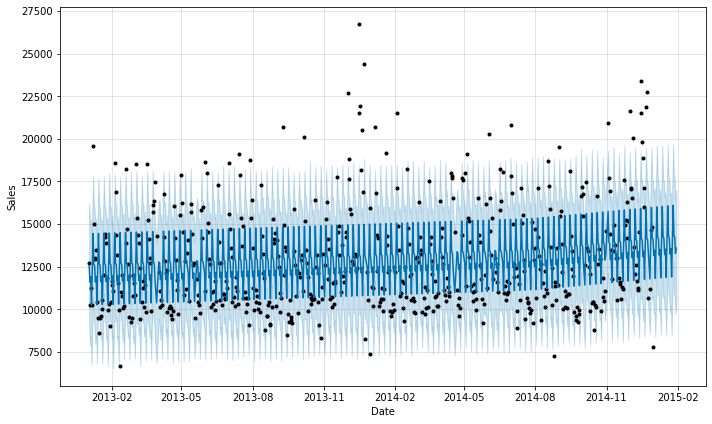

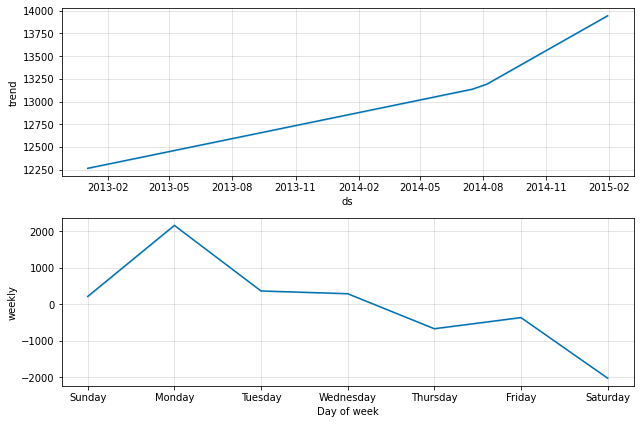

In [8]:
forecast = prediction[1].iloc[-30:][['ds','yhat','yhat_lower',	'yhat_upper']]
df_test1 = df_test[df_test['Store'] == 84][['Date','Sales']]
df_test1 = df_test1[(df_test1['Date'] >= '2015-01-01') & (df_test1['Date'] <= '2015-01-30')]

df_test1 = pd.merge(df_test1, forecast, how='left', left_on='Date' , right_on='ds').drop('ds',axis=1) # only count dates when the store is open
print('RMSE:', math.sqrt(mean_squared_error(df_test1['Sales'], df_test1['yhat'])))
                                    
# plotting the forecast
figure = prediction[0].plot(prediction[1], xlabel = 'Date', ylabel = 'Sales')
figure2 = prediction[0].plot_components(prediction[1])

## Holiday

In [9]:
# State Holidays
state_holidays = df_sales[(df_sales['StateHoliday'] == 'a')|(df_sales['StateHoliday'] == 'b')|(df_sales['StateHoliday'] == 'c')]['Date'].unique()
df_state = pd.DataFrame()
df_state['ds'] = pd.to_datetime(state_holidays)
df_state['holiday'] = 'state_holiday'

df_state.shape

(35, 2)

In [10]:
# School Holidays
school_holidays = df_sales[df_sales['SchoolHoliday'] == 1]['Date'].unique()
df_school = pd.DataFrame()
df_school['ds'] = pd.to_datetime(school_holidays)
df_school['holiday'] = 'school_holidays'

df_school.shape

(477, 2)

In [11]:
df_holiday = pd.concat((df_state, df_school))
df_holiday

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
472,2014-04-13,school_holidays
473,2014-04-06,school_holidays
474,2013-10-13,school_holidays
475,2013-10-06,school_holidays


In [12]:
def sales_prediction(Store_ID, sales_df, holidays, periods):
  sales_df = sales_df[sales_df['Store'] == Store_ID]
  sales_df = sales_df[['Date','Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})
  sales_df = sales_df.sort_values('ds')

  # fitting the model
  model = Prophet(holidays = holidays)
  model.fit(sales_df)
  # making prediction
  future = model.make_future_dataframe(periods=periods)
  forecast = model.predict(future)

  return model, forecast

In [13]:
prediction_h = sales_prediction(84, df_train, df_holiday, 30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 2064.9501739097886


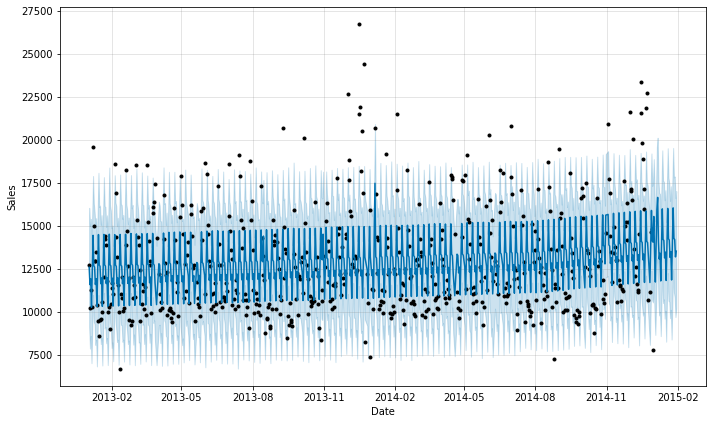

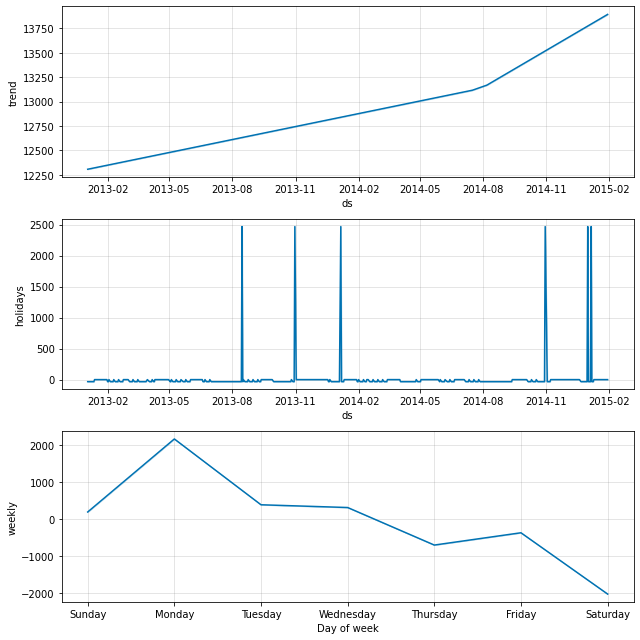

In [14]:
forecast = prediction_h[1].iloc[-30:][['ds','yhat','yhat_lower',	'yhat_upper']]
df_test1 = df_test[df_test['Store'] == 84][['Date','Sales']]
df_test1 = df_test1[(df_test1['Date'] >= '2015-01-01') & (df_test1['Date'] <= '2015-01-30')]

df_test1 = pd.merge(df_test1, forecast, how='left', left_on='Date' , right_on='ds').drop('ds',axis=1) # only count dates when the store is open
print('RMSE:', math.sqrt(mean_squared_error(df_test1['Sales'], df_test1['yhat']))) # Lower RMSE when holiday is taken into account
                                    
# plotting the forecast
figure = prediction_h[0].plot(prediction_h[1], xlabel = 'Date', ylabel = 'Sales')
figure2 = prediction_h[0].plot_components(prediction_h[1])